## Option pricing with neural network under the Heston93 model

The content of the following notebook is to show to price European call options with a neural network. We will first generate a synthetic dataset under the Heston93 model and then train a neural network to perform the pricing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Neural_network_utils import NN_generator, ParamGenerator
from Stochastic_processes import Heston93
from time import time
from Option_lib import implied_vol
import multiprocess as mp 

In [21]:
def heston_price_generator(data):
    
    prices = np.empty((len(data), 1)) 
    S = np.empty((len(data), 1)) 
    ImpliedVolatility = np.empty((len(data), 1)) 
    
    for i in range(0, len(data)):
        
        T = data[i,0]
        
        theta = data[i,2]
        sigma = data[i,3]
        rho = data[i,4]
        nu0 = data[i,5]
        K = data[i,6]
        r = data[i,7]
        
        k = data[i,8]
        
        sk = data[i,1]
        # print(sk)
        S[i] = K * sk
        
        model = Heston93(mu=r, k=k, theta=theta, sigma=sigma, rho=rho)
    
        # prices[i,0] = model.cos_pricing(S[i,0], nu0, K, T, 'call')
        prices[i,0] = model.Fourier_call_pricing(K, T, S[i,0], nu0)
        # prices[i,0] = model.mc_call_pricing(int(T*252), K, T, S[i,0], nu0, 0, 10)
        
        del model
        
        v = implied_vol(K, T,  prices[i,0], S[i,0], .001, 1, 0)
        ImpliedVolatility[i,0] = v 
        
    data2 = np.hstack((data, S, prices, ImpliedVolatility))
        
    df_data = pd.DataFrame(data=data2, 
                            columns=['maturity','S/K', 'theta', 'sigma', 'rho', 'nu0', 'strike', 'rate', 'kappa', 'S', 'price', 'imp_vol'])
    
    return df_data

In [38]:
np.random.seed(42)

n = 20000

T_lb = 1/252
T_ub = 1 

sk_lb = .5
sk_ub = 2

theta_lb = .01
theta_ub = 1

sigma_lb = .01
sigma_ub = 1

rho_lb = -1
rho_ub = 1

nu0_lb = 0.1
nu0_ub = .5

K_lb = .01
K_ub = 100

r_lb = -.025
r_ub = .035

l_bounds = np.array([T_lb, sk_lb, theta_lb, sigma_lb, rho_lb, nu0_lb, K_lb, r_lb])
u_bounds = np.array([T_ub, sk_ub, theta_ub, sigma_ub, rho_ub, nu0_ub, K_ub, r_ub])

data = ParamGenerator(n, len(l_bounds), l_bounds, u_bounds)

theta_k_ub = .5
kappa = theta_k_ub - data[:,3]**2/2 
kappa = np.reshape(kappa, (len(kappa),1))

kappa = kappa * np.random.uniform(0,1,(len(data),1))
kappa = kappa/np.reshape(data[:,5],(len(data),1))
         
data = np.hstack((data, kappa))


prices = np.empty((len(data), 1)) 
S = np.empty((len(data), 1)) 
ImpliedVolatility = np.empty((len(data), 1)) 

data2 = [] 

I = int(len(data)/10)

for i in range(0, 10):
    data2.append(data[I*i:I*(i+1),:])

start = time()

print('So it begins\n')

# with mp.Pool(10) as pool:
#     res = pool.map(heston_price_generator, data2)
   
# df_data = pd.concat(res)
df_data = heston_price_generator(data)
end = time()

print('Elapsed time : '+str(end-start))
print()

df_data = df_data.dropna()
# df_data.to_csv('Heston93_params5.csv')


So it begins

Elapsed time : 234.04998636245728



In [39]:
df_data

,maturity,S/K,theta,sigma,rho,nu0,strike,rate,kappa,S,price,imp_vol
0,0.513937,0.896350,0.348065,0.044750,0.272685,0.373445,96.613531,0.012695,0.500462,86.599512,11.523605,6.176770e-01
1,0.606944,1.912824,0.917553,0.105315,0.568608,0.309071,34.909107,0.023281,1.520962,66.774962,33.839889,7.663643e-01
2,0.797918,1.418797,0.469172,0.381094,-0.746874,0.456359,81.273864,0.012612,0.685518,115.311080,44.832967,7.061133e-01
3,0.912272,0.603222,0.707884,0.435145,-0.605408,0.371616,13.085497,0.000223,0.652961,7.893465,0.625347,6.140948e-01
4,0.776188,1.245861,0.258860,0.848176,0.960943,0.219240,39.541223,0.034928,0.099842,49.262887,11.946311,3.776895e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.902303,1.991705,0.709339,0.128154,0.439186,0.449925,42.087774,-0.006630,0.958642,83.826446,44.836748,7.107597e-01
19996,0.381823,1.545982,0.051055,0.355677,0.065842,0.124986,63.745799,-0.012153,0.163585,98.549889,34.679927,9.536743e-10
19997,0.073290,1.182844,0.551208,0.902916,-0.951893,0.269156,89.867686,-0.023850,0.104226,106.299470,17.381426,5.511428e-01
19998,0.254042,1.253627,0.315774,0.169835,-0.379776,0.428917,3.442146,-0.011390,0.501884,4.315168,1.050220,6.418075e-01


In [40]:
X = df_data.loc[:, ['maturity', 'imp_vol', 'S/K', 'rate','strike'] ]

Y = df_data.loc[:,'price']/df_data.loc[:, 'strike']    

X = df_data.loc[:, ['maturity', 'imp_vol', 'S/K', 'rate', 'strike'] ]
# X['S/K'] = X['S/K']**(-1)
# Y = df_data.loc[:,'price']/df_data['S']

Y = df_data.loc[:,'price']/df_data.loc[:, 'strike']    

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Build the model 

# Number/type of hyperparameters(i.e., nodes, activation function, dropout, layers) are explored in a different notebook
# The following architecture is fairly generic and can be found in most tutorials on regression

# Number of nodes in Neural Network

nNodes = 500
nLayers = 4
InputShape = len(X.columns)
BatchSize = 32
nEpochs = 200

model1 = NN_generator(InputShape, nLayers, nNodes, 'relu','mse','adam')


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_25 (Dense)            (None, 500)               3000      
                                                                 
 dense_26 (Dense)            (None, 500)               250500    
                                                                 
 dense_27 (Dense)            (None, 500)               250500    
                                                                 
 dense_28 (Dense)            (None, 500)               250500    
                                                                 
 dense_29 (Dense)            (None, 1)                 501       
                                                                 
Total params: 755,001
Trainable params: 755,001
Non-trainab

In [41]:
start = time()

# Set the number of CPU threads

fitted_model = model1.fit(x_train, y_train, epochs=nEpochs, batch_size=BatchSize,
                            validation_split = 0.25, verbose = 1)

end = time()

print('Elapsed time : ' + str(end-start))

Epoch 1/200
352/352 [==============================] - 2s 5ms/step - loss: 0.3823 - val_loss: 0.0356
Epoch 2/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0399
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 4/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0039 - val_loss: 0.0128
Epoch 5/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 8.7062e-04
Epoch 7/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 8.8809e-04
Epoch 9/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0040 - val_loss: 7.1616e-04
Epoch 10/200
352/352 [==============================] - 2s 5ms/step - loss: 8.2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



352/352 [==============================] - 2s 6ms/step - loss: 1.5377e-05 - val_loss: 2.0697e-06
Epoch 191/200
352/352 [==============================] - 2s 6ms/step - loss: 1.2757e-05 - val_loss: 2.6219e-05
Epoch 192/200
352/352 [==============================] - 2s 7ms/step - loss: 8.4431e-05 - val_loss: 5.5261e-06
Epoch 193/200
352/352 [==============================] - 2s 7ms/step - loss: 7.7830e-05 - val_loss: 5.0068e-06
Epoch 194/200
352/352 [==============================] - 3s 8ms/step - loss: 6.2232e-06 - val_loss: 1.4992e-05
Epoch 195/200
352/352 [==============================] - 3s 8ms/step - loss: 2.2692e-05 - val_loss: 1.3905e-05
Epoch 196/200
352/352 [==============================] - 2s 7ms/step - loss: 1.8111e-05 - val_loss: 2.7622e-06
Epoch 197/200
352/352 [==============================] - 2s 6ms/step - loss: 5.5116e-05 - val_loss: 2.4061e-06
Epoch 198/200
352/352 [==============================] - 2s 6ms/step - loss: 1.9762e-05 - val_loss: 3.2182e-05
Epoch 199/200
3

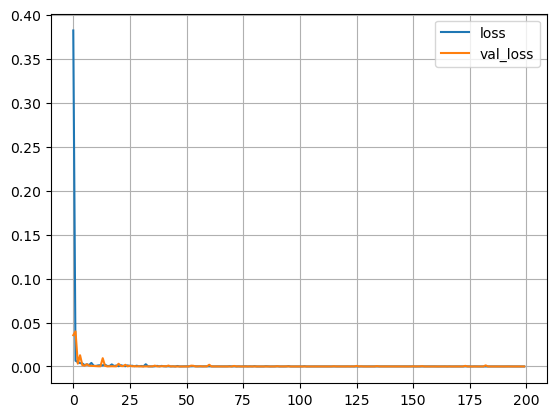

In [42]:
plt.plot(fitted_model.history['loss'], label='loss')
plt.plot(fitted_model.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

157/157 [==============================] - 1s 3ms/step


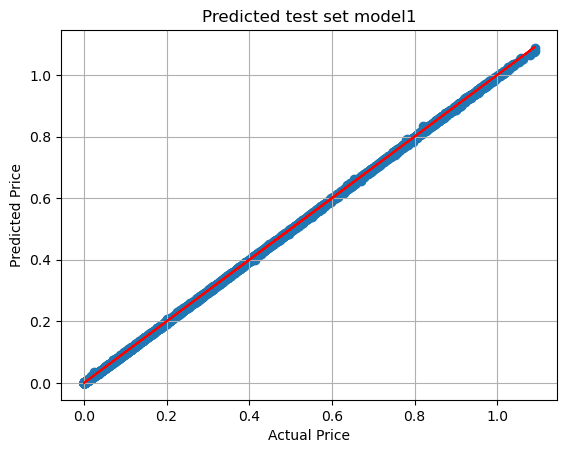

In [43]:
predictions = model1.predict(x_test)

# plt.figure(figsize = (10,10))
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot(y_test, y_test, 'r')
plt.grid(True)
plt.title('Predicted test set model1')
plt.show()
